In [2]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 5)

train = pd.read_pickle('Data/student_train_logs_agg')
test = pd.read_pickle('Data/student_test_logs_agg')

target = 'isSTEM'
IDcol = 'ITEST_id'
columns_not_keep = [
    target,
    IDcol,
    'SY ASSISTments Usage',
    'skill',
    'problemId',
    'assignmentId',
    'assistmentId',
    'problemType',
    'SY ASSISTments Usage_std',
    'skill_std',
    'problemId_std',
    'assignmentId_std',
    'assistmentId_std',
    'problemType_std'
]



/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
test_isSTEM = []

for i in range(test.shape[0]):
    idx = test.iloc[i].name
    if idx in train.index:
        test_isSTEM.append(idx)

In [4]:
train_balanced = pd.concat([train[train['isSTEM'] == 1], train[train['isSTEM'] == 0][:150]])
train = train_balanced.sample(frac=1)
train.head()

,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,AveResConf,AveResFrust,AveResOfftask,AveResGaming,...,skill_2_std,problemType_0_std,problemType_1_std,problemType_2_std,assignmentId_0_std,assignmentId_1_std,assignmentId_2_std,isSTEM,MCAS,SchoolId
ITEST_id,,,,,,,,,,,,,,,,,,,,,
2535,0.062432,0.064571,0.313514,-0.880196,0.262099,0.603295,0.093166,0.315453,0.324418,0.144998,...,0.821456,0.741741,0.632362,0.399627,0.232322,0.271562,0.368624,0.0,13.0,4.0
205,0.229988,0.126401,0.445407,-0.623568,0.242691,0.658863,0.112356,0.132230,0.185330,0.077827,...,1.106808,0.506528,1.009871,0.717749,0.649313,0.769076,0.567617,0.0,29.0,2.0
3215,0.140286,0.100057,0.271812,-0.611129,0.202719,0.655779,0.100014,0.185093,0.115070,0.265841,...,1.041172,0.757247,0.985914,0.264950,1.024776,0.696139,1.463564,1.0,31.0,4.0
1203,0.203324,0.108907,0.442907,-0.812111,0.254045,0.675430,0.135405,0.139763,0.206802,0.045561,...,1.161539,0.822885,0.965719,0.284454,0.662909,1.101921,0.550042,0.0,35.0,2.0
1417,0.177828,0.087722,0.423077,-0.814075,0.290882,0.620887,0.106159,0.121848,0.281970,0.044298,...,1.389322,0.529831,1.030239,0.494991,0.603629,1.031996,0.930544,0.0,30.0,2.0


In [5]:
train.isnull().any().any()

False

In [6]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=7, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc') 
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [7]:
predictors = [x for x in train.columns if x not in columns_not_keep]

xgb1 = XGBClassifier(
 learning_rate =0.001,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

[0]	train-auc:0.868934+0.0171901	test-auc:0.601055+0.145613
[1]	train-auc:0.932308+0.0150307	test-auc:0.596216+0.124888
[2]	train-auc:0.95369+0.0142493	test-auc:0.595953+0.144901
[3]	train-auc:0.961305+0.0136327	test-auc:0.614474+0.133579
[4]	train-auc:0.969446+0.00944158	test-auc:0.612859+0.145271
[5]	train-auc:0.974542+0.00901368	test-auc:0.630661+0.132019
[6]	train-auc:0.976681+0.00737973	test-auc:0.63665+0.123776
[7]	train-auc:0.977916+0.00707445	test-auc:0.6447+0.130916
[8]	train-auc:0.978483+0.00572691	test-auc:0.641409+0.121226
[9]	train-auc:0.979052+0.00640769	test-auc:0.645218+0.1195
[10]	train-auc:0.980648+0.00615681	test-auc:0.651189+0.111578
[11]	train-auc:0.980622+0.00538145	test-auc:0.662573+0.109893
[12]	train-auc:0.981417+0.00445398	test-auc:0.666143+0.111865
[13]	train-auc:0.982904+0.00404153	test-auc:0.666171+0.111315
[14]	train-auc:0.983646+0.00486958	test-auc:0.656103+0.104781
[15]	train-auc:0.983779+0.00447715	test-auc:0.657246+0.0959681
[16]	train-auc:0.984037+0.0

TypeError: 'str' object is not callable

In [8]:
param_test1 = {
 'max_depth': list(range(8,15,2)),
 'min_child_weight': list(range(1,6,2))
}

xgb2 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=7)
gsearch1.fit(train[predictors], train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.66838, std: 0.08944, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.68177, std: 0.10915, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.67952, std: 0.10501, params: {'max_depth': 12, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 12, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 12, 'min_child_weight': 5},
  mean: 0.67952, std: 0.10501, params: {'max_depth': 14, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 14, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 14, 'min_child_weight': 5}],
 {'max_depth': 8, 'min_child_w

In [10]:
param_test2 = {
 'max_depth': [7,8,9],
 'min_child_weight':[2, 3, 4]
}

xgb3 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=8,
    min_child_weight=8,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


([mean: 0.66989, std: 0.08129, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.68140, std: 0.10506, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.66445, std: 0.09061, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.66488, std: 0.09066, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 8, 'min_child_weight': 3},
 0.6845738295318127)

* max_depth: 10
* min_child_weight: 1
* learning_rate: 0.05
* n_estimators: 105

In [11]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0, 5)]
}

xgb4 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=8,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

gsearch3 = GridSearchCV(estimator = xgb4, param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.68457, std: 0.09877, params: {'gamma': 0.0},
  mean: 0.67921, std: 0.10688, params: {'gamma': 0.1},
  mean: 0.69003, std: 0.10011, params: {'gamma': 0.2},
  mean: 0.68400, std: 0.09766, params: {'gamma': 0.3},
  mean: 0.68484, std: 0.10716, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.690032831314344)

[0]	train-auc:0.825703+0.0133051	test-auc:0.613504+0.0616035
[1]	train-auc:0.879937+0.015878	test-auc:0.6534+0.0454633
[2]	train-auc:0.907728+0.0153927	test-auc:0.651606+0.0476544
[3]	train-auc:0.924656+0.00795382	test-auc:0.660779+0.0466918
[4]	train-auc:0.934131+0.00785356	test-auc:0.684165+0.0408055
[5]	train-auc:0.946648+0.00429878	test-auc:0.683282+0.0470243
[6]	train-auc:0.953114+0.00513457	test-auc:0.681562+0.0418942
[7]	train-auc:0.959101+0.00679389	test-auc:0.680855+0.0366126
[8]	train-auc:0.958929+0.00603333	test-auc:0.683934+0.0551738
[9]	train-auc:0.962464+0.00511084	test-auc:0.684439+0.0495448
[10]	train-auc:0.965667+0.00451427	test-auc:0.691553+0.0546397
[11]	train-auc:0.968905+0.00670742	test-auc:0.692504+0.0493168
[12]	train-auc:0.971113+0.0064911	test-auc:0.692397+0.0529461
[13]	train-auc:0.974366+0.00606862	test-auc:0.695332+0.0542382
[14]	train-auc:0.974482+0.00560851	test-auc:0.696673+0.0487119
[15]	train-auc:0.976233+0.00601438	test-auc:0.697433+0.0504728
[16]	trai

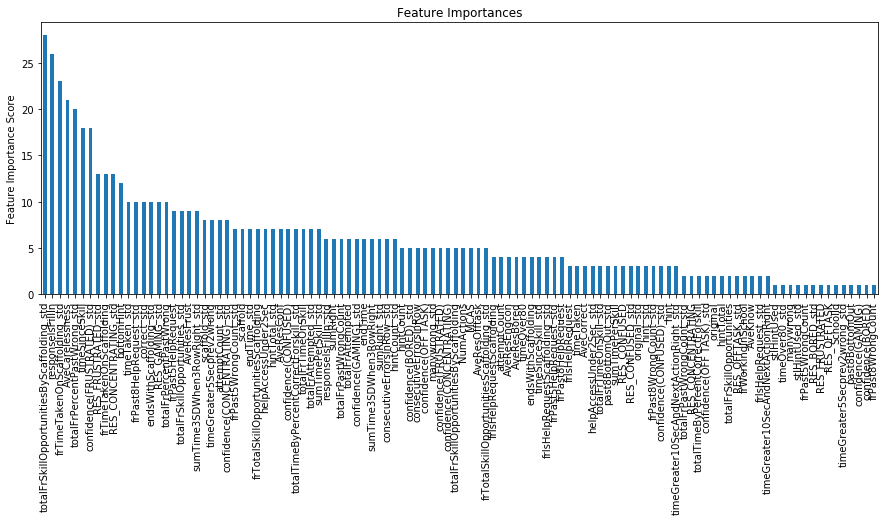

In [12]:
xgb5 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, predictors, cv_folds=7)

In [14]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb6 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=54,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

gsearch4 = GridSearchCV(estimator = xgb6, param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.67489, std: 0.09900, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.67637, std: 0.07512, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.68497, std: 0.08947, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.68170, std: 0.10513, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.67536, std: 0.08987, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.67178, std: 0.07828, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.69383, std: 0.08868, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.68764, std: 0.07974, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.65949, std: 0.07925, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.67305, std: 0.09498, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.69003, std: 0.10011, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.68001, std: 0.10316, params: {'colsample_bytree': 0.8, 'subsample'

[0]	train-auc:0.752129+0.0451994	test-auc:0.550088+0.0664434
[1]	train-auc:0.839161+0.0215305	test-auc:0.566128+0.0621279
[2]	train-auc:0.884169+0.0237929	test-auc:0.594219+0.0797673
[3]	train-auc:0.898888+0.0191866	test-auc:0.602995+0.0848707
[4]	train-auc:0.910479+0.0166618	test-auc:0.614087+0.097958
[5]	train-auc:0.923801+0.0128239	test-auc:0.63736+0.0943695
[6]	train-auc:0.930657+0.0137693	test-auc:0.632031+0.088722
[7]	train-auc:0.932263+0.0142421	test-auc:0.642021+0.0798735
[8]	train-auc:0.937832+0.0143945	test-auc:0.643957+0.0885467
[9]	train-auc:0.942395+0.0129897	test-auc:0.65446+0.0805147
[10]	train-auc:0.945931+0.0132558	test-auc:0.667304+0.0746537
[11]	train-auc:0.950418+0.0129729	test-auc:0.664331+0.0688497
[12]	train-auc:0.955029+0.0106813	test-auc:0.65443+0.0661851
[13]	train-auc:0.959597+0.00841496	test-auc:0.661697+0.0694408
[14]	train-auc:0.962765+0.0100005	test-auc:0.652926+0.0690905
[15]	train-auc:0.965308+0.00933208	test-auc:0.64739+0.0697155
[16]	train-auc:0.96637

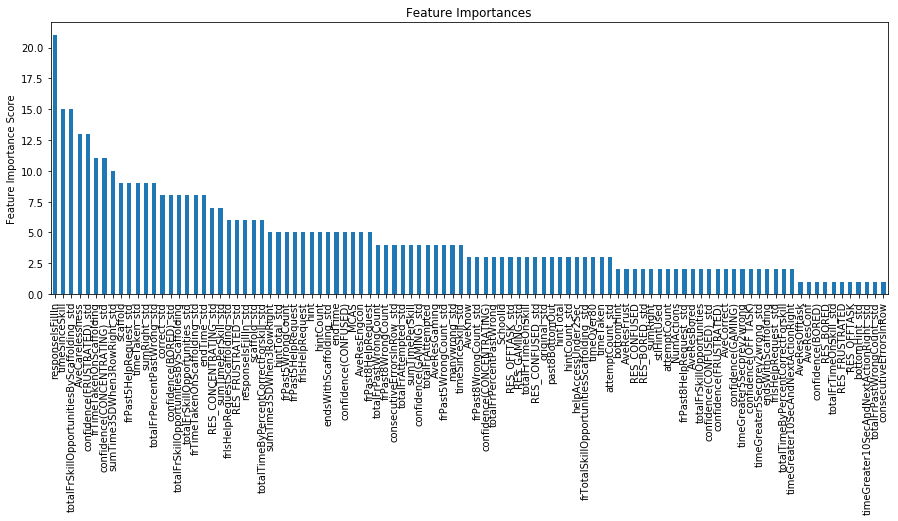

In [8]:
xgbFinal = XGBClassifier(
 learning_rate =0.05,
 n_estimators=54,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.7,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgbFinal, train, predictors, cv_folds=7)

## Predictions

In [11]:
predictors = [x for x in train.columns if x not in columns_not_keep]
for probas in xgbFinal.predict(test[predictors]):
    print(probas, end=',')

1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,